**извлечение признаков из текста на естественном языке**

классификатор текстов

частотный анализ с очисткой стоп-слов (TF)

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import numpy as np
import pandas as pd
import re
import gzip

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
%matplotlib inline

In [4]:
pd.options.display.max_colwidth = 200  

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [6]:
data.sample(2)

,text,tag
458,"Дело о взрывах в Брюсселе: сообщник ""мужчины в шляпе"" признан виновным\n\n6 декабря 2016 в 18:33\n\nРусская служба Би-би-си\n\nСообщник «мужчины в шляпе», 26-летний житель Бирмингема Закария Буфас...",politics
1093,Белорусы заняли 5-е места в супермиксте и миксте на втором этапе Кубка IBU в Риднау\n\n8 декабря 2016 в 18:43\n\nSPORT.TUT.BY\n\nБелорусские команды заняли 5-е места в супермиксте и миксте в старт...,sport


---

In [7]:
# # from nltk.stem.snowball import SnowballStemmer
# from nltk.corpus import stopwords as nltk_stopwords

# stopwords = set(nltk_stopwords.words('russian') )

In [8]:
with gzip.open('../data/text/stop-nltk.txt.gz','rt',encoding='utf-8') as f: 
    stopwords = set([ w.strip() for w in  f.read().split() if w.strip() ] )

print('количество стоп-слов:',len(stopwords))
# sorted(stopwords)

количество стоп-слов: 151


In [9]:
%%time 

data['text_clean'] = data['text'].str.lower() # приведение в lowercase

# замена символов-разделителей (-,_) на пробел
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\W', ' ', s))
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'_', ' ', s))

# замена цифр
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\b\d+\b', ' ', s))

# делим строки на слова (токенизация)
data['text_clean'] = data['text_clean'].apply(lambda t: [ w.strip() for w in t.split() if len(w.strip())>2 ] )

# удаление лишних слов 
data['text_clean'] = data['text_clean'].apply(lambda t:[w for w in t if w not in stopwords])

# стемминг, выделение основы слова
# data['text_clean'] = data['text_clean'].apply( lambda t: Stemmer('russian').stemWords(t) )
# data['text_clean'] = data['text_clean'].apply(lambda t:[ SnowballStemmer('russian').stem(w) for w in t if w])


CPU times: user 569 ms, sys: 22.8 ms, total: 592 ms
Wall time: 593 ms


In [10]:
data['text_clean'] = data['text_clean'].apply(lambda t:' '.join(t))

In [11]:
data[['text_clean']].sample(2)

,text_clean
1975,reuters рынок акций сша закрылся разнонаправленно dow jones прибавил investing com фондовый рынок сша завершил торги понедельника разнонаправленно счет укрепления секторов рынок демонстрирует фоне...
2197,пожарные локализовали возгорание деревянных конструкций складе пиломатериалов улице мироновской востоке москве площадь возгорания составила тушение пожара продолжается пострадавших говорится сообщ...


##  HashingVectorizer

In [14]:
from sklearn.feature_extraction.text import HashingVectorizer

tf = HashingVectorizer(n_features=16384, norm='l2')
tf.fit( data['text_clean'])

HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
         decode_error='strict', dtype=<class 'numpy.float64'>,
         encoding='utf-8', input='content', lowercase=True,
         n_features=16384, ngram_range=(1, 1), non_negative=False,
         norm='l2', preprocessor=None, stop_words=None, strip_accents=None,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None)

## формируем датасеты

In [16]:
X = tf.transform( data['text_clean'] )
X.shape

(3196, 16384)

In [17]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [18]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

---

In [19]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.9, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((319, 16384), (319,), (2877, 16384), (2877,))

## обучаем

In [20]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.19,
       validation_fraction=0.1, verbose=0, warm_start=False)

## тестируем

In [21]:
o = clf.predict(X_train)

In [22]:
accuracy_score(y_train,o)

1.0

---

In [23]:
o = clf.predict(X_test)

In [24]:
accuracy_score(y_test,o)

0.7274939172749392

In [25]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.85      0.73      0.79       227
           1       0.71      0.73      0.72       319
           2       0.63      0.66      0.65       240
           3       0.50      0.22      0.31        86
           4       0.84      0.78      0.81       396
           5       0.75      0.88      0.81       542
           6       0.42      0.31      0.36        58
           7       0.24      0.61      0.34        41
           8       0.71      0.93      0.81       200
           9       0.57      0.20      0.30       133
          10       0.87      0.90      0.89       340
          11       0.66      0.65      0.66       262
          12       0.33      0.03      0.06        33

   micro avg       0.73      0.73      0.73      2877
   macro avg       0.62      0.59      0.58      2877
weighted avg       0.73      0.73      0.72      2877



---

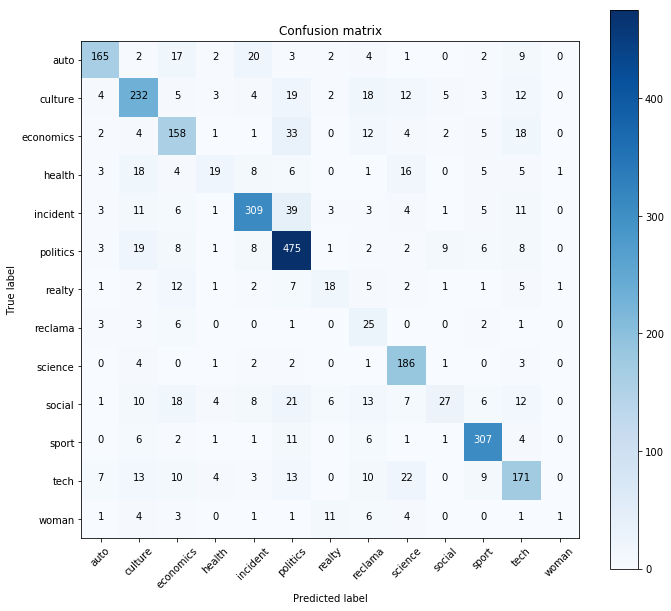

In [26]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [27]:
o = clf.predict(X)

In [28]:
labels_inv = { labels[k]:k for k in labels}
# labels_inv

In [29]:
i = np.random.randint(len(data))
print('tag:',data.iloc[i,1])
print('predict:',labels_inv[o[i]])
print('- - - - - - - - - - - - - - - - - - \n')
print(data.iloc[i,0])


tag: sport
predict: reclama
- - - - - - - - - - - - - - - - - - 

В Англии парень эффектно спас девушку после неудачного штрафного

6 декабря 2016 в 9:53

SPORT.TUT.BY

В самых низких лигах Англии иногда происходят яркие случаи отзывчивости среди болельщиков.

После исполнения штрафного мяч, пущенный как из пушки, полетел не в ворота, а прямо в болельщицу, которая располагалась за ними.

Но на помощь пришел парень, который проявил чудеса реакции и ловко отбил мяч.

Внимание! У вас отключен JavaScript, ваш браузер не поддерживает HTML5, или установлена старая версия проигрывателя Adobe Flash Player.
